
![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - masked sky
In this notebook you perfoom QE and iterative lensing reconstruction for a single simulation, and for a masked sky.
This notebook is very similar to the [full-sky tutorial](./interactive_mwe.ipynb), but this time, we assume that the data only contains a part of the sky.

The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.

We generate a simple mask leaving us with a sky fraction of about $8$ percent.
Masked data for iterative lensing reconstruction results in a large mean-field, and biases the lensing potential estimate.
To remove this bias, you will estimate the mean-field from a set of simulations.

We will use an isotropic noise model and ignore that the data is masked when we deproject the B-modes.
This is an approximation, and it were better to use the `build_OBD` job to create a better noise model.
However, this is out of scope for this tutorial.

At the end of this tutorial, you will plot the mean-field subtracted lensing potential estimate and obtain delensed power spectra to calculate the residual lensing amplitude on a masked sky with binned power spectra.

The configuration file is [here](./conf_mwe_maskedsky.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Simulationdata` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


In [2]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj
import numpy as np
import healpy as hp

from delensalot.utility.utils_hp import almxfl, alm_copy
import matplotlib.pyplot as plt

from delensalot.run import run

from delensalot.utility import plot_helper as ph

bpl, bpu = (10,1000)
def scale_and_bandpass(data):
    ll = np.arange(0,3001)
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)

fn = opj(os.getcwd(), 'conf_mwe_maskedsky.py')

mpisupport: False, pmisupport: False
disabling mpi


# Create mask
Any mask will do as long as the remaining sky fraction is large enough to calculate an unbinned power spectrum of the residual maps later

fsky: 0.083


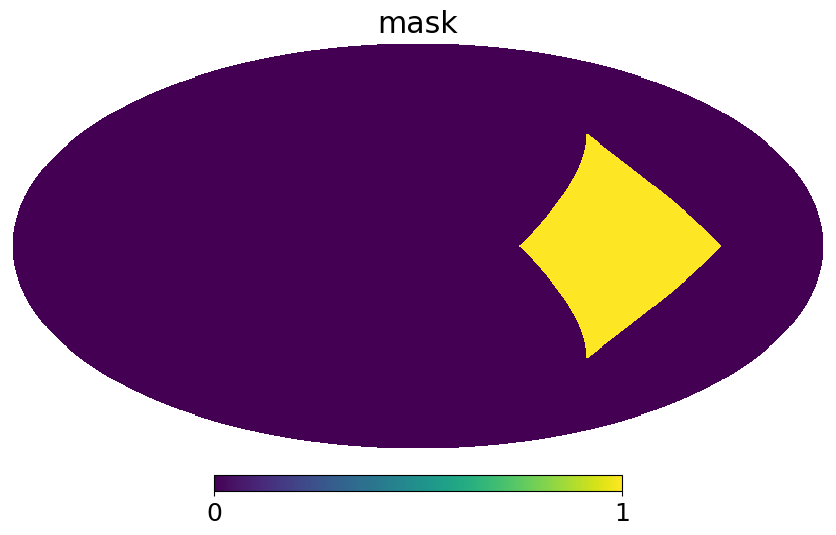

In [3]:
m = np.zeros(hp.nside2npix(1))
m[[7]] = 1
# rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=2048),0.1))
mask = hp.ud_grade(m, nside_out=256)
hp.mollview(mask, title='mask')
# hp.mollview(rhits, title='rhits')
print('fsky: {:.3f}'.format(np.mean(m)))

In [4]:
m = np.zeros(hp.nside2npix(1))
m[[7]] = 1
# rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=2048),0.1))
mask = hp.ud_grade(m, nside_out=2048)
# hp.mollview(mask, title='mask')
# hp.mollview(rhits, title='rhits')
print('fsky: {:.3f}'.format(np.mean(m)))

mask_fn = opj(os.environ['SCRATCH'], 'analysis/mfda_maskedsky_lminB200/mask.fits')
# rhits_fn = opj(os.environ['SCRATCH'], 'delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky/rhits.fits')
if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    # hp.write_map(rhits_fn, rhits)
    print('mask and rhits stored at {}'.format(os.path.dirname(mask_fn)))

fsky: 0.083


# QE lensing reconstruction
The following cell,
 
 * line 1: selects the configuration file,
 * line 2: initialises delensalot for a QE lensing reconstruction job (`job_id`),
 * line 3: perfroms lensing reconstruction and calculates both, the lensing potential, and the $B$-lensing template.

`.run()` also generates CMB simulations and stores them at `DLENSALOT_data.class_parameters.lib_dir`. If this path is not convenient, please choose one that works for you.

This cell will take a while as it also calculates the QE mean-field (and is calculated from $5$ simulations in this tutorial). This is needed, as the masking of the data induces a strong bias in the low-$L$ lensing potential.
For QE, once the mean-field is calculated, it is subtracted from the QE lensing potential estimate to remove this bias.
This QE estimate is later used as a starting point for iterative lensing reconstruction.

This cell takes ~15 min * N (QE estimates to calculate mean-field) + ~30 sec * N (generation of simulation data), and N is the number of simulations

In [4]:
fn = opj(os.getcwd(), 'conf_mwe_maskedsky.py')
delensalot_runner = run(config_fn=fn, job_id='generate_sim', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 01:14:26


In [5]:
fn = opj(os.getcwd(), 'conf_mwe_maskedsky.py')
delensalot_runner = run(config_fn=fn, job_id='QE_lensrec', verbose=False)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()


clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 02:24:40


In [4]:
LL = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor_L = (LL*(LL+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

mf_QE = ana_mwe.get_meanfield_normalized(0)
plm_QE = ana_mwe.get_plm(0, [0])

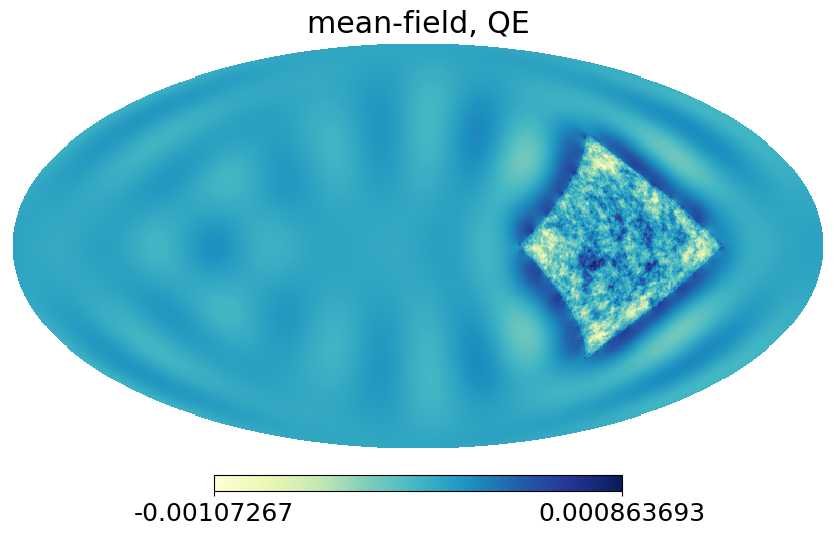

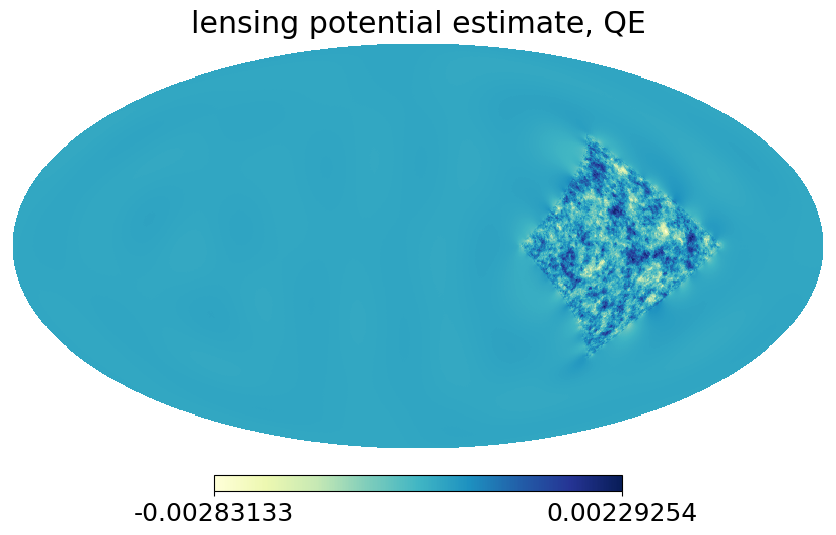

In [5]:
hp.mollview(hp.alm2map(scale_and_bandpass(mf_QE), nside=256), title='mean-field, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=256), title='lensing potential estimate, QE', cmap='YlGnBu')

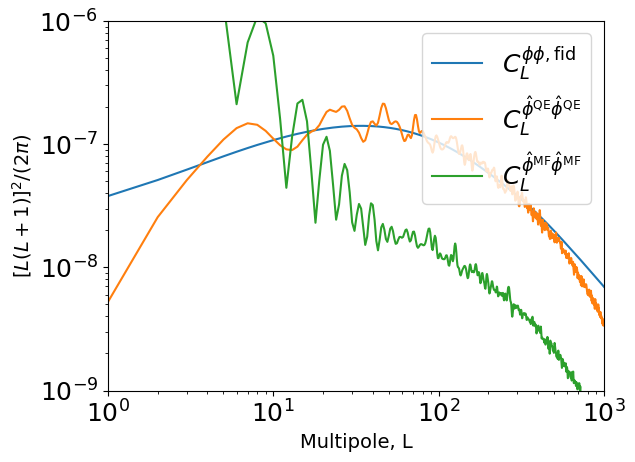

In [ ]:
plt.plot(scale_factor_L*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')

plt.plot(scale_factor_L*hp.alm2cl(mf_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MF}\hat{\phi}^{\rm MF}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,1e-6)
plt.yscale('log')

# iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The settings can be chosen in the configuration file.

In [ ]:
delensalot_runner = run(config_fn=fn, job_id='MAP_lensrec', verbose=False)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

# Check your results
## lensing potential and mean-field
After completion of above cells, we can look at the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics of the lensing potential estimate for simulation `idx` and iteration `its`

In [ ]:
mask = hp.read_map(ana_mwe.mask_fn)
fsky = np.mean(mask)

Loaded 5 iterations


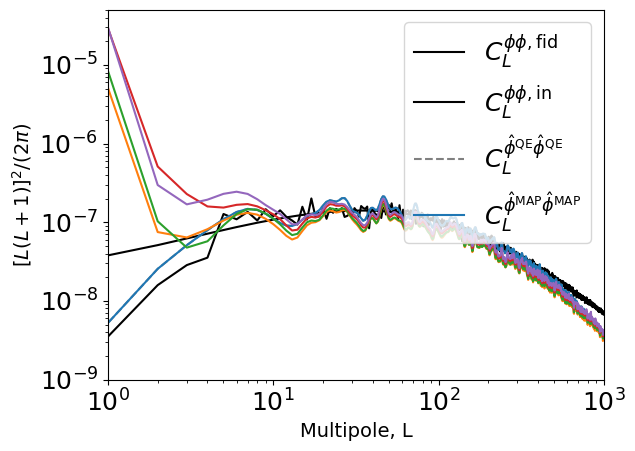

In [ ]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, np.arange(ana_mwe.itmax))
plm_in = alm_copy(ana_mwe.simulationdata.get_sim_phi(0, space='alm'), None, *ana_mwe.lm_max_qlm)

print('Loaded {} iterations'.format(len(plm_MAP)))

plt.plot(scale_factor_L*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$', color='black')
plt.plot(scale_factor_L*hp.alm2cl(plm_in), label=r'$C_L^{\phi\phi,{\rm in}}$', color='black')
plt.plot(scale_factor_L*hp.alm2cl(plm_QE)/fsky, label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$', color='grey', ls='--')
for n in range(0, len(plm_MAP)):
    label = r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$' if n == 0 else None
    plt.plot(scale_factor_L*hp.alm2cl(plm_MAP[n])/fsky, label=label)
    # plt.plot(scale_factor_L*hp.alm2cl(plm_mf)/fsky, label=label, color='black')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-5)
plt.yscale('log')

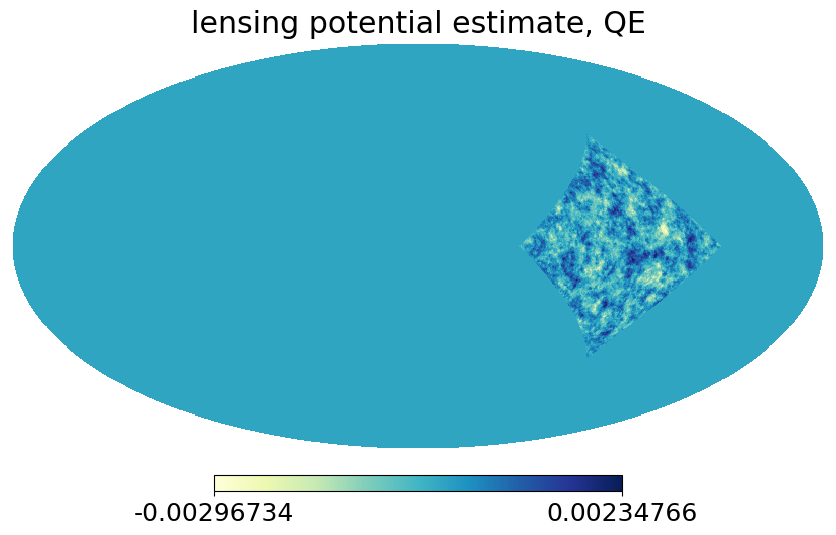

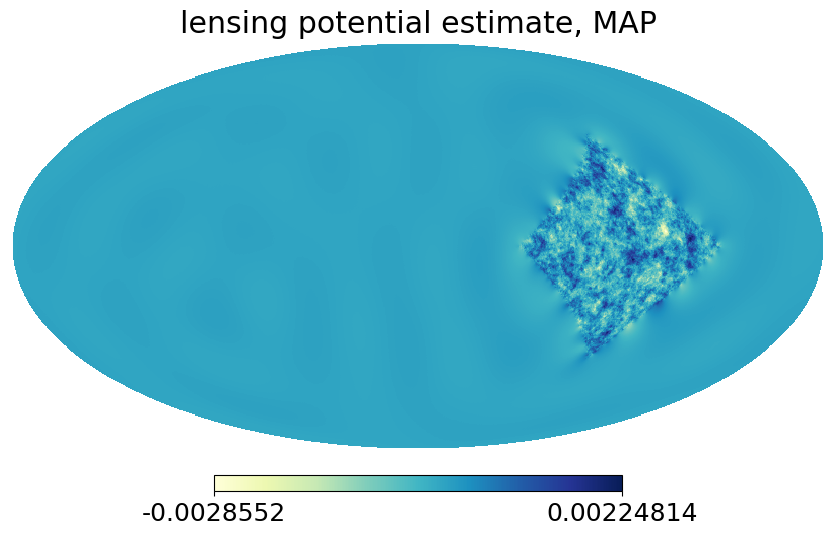

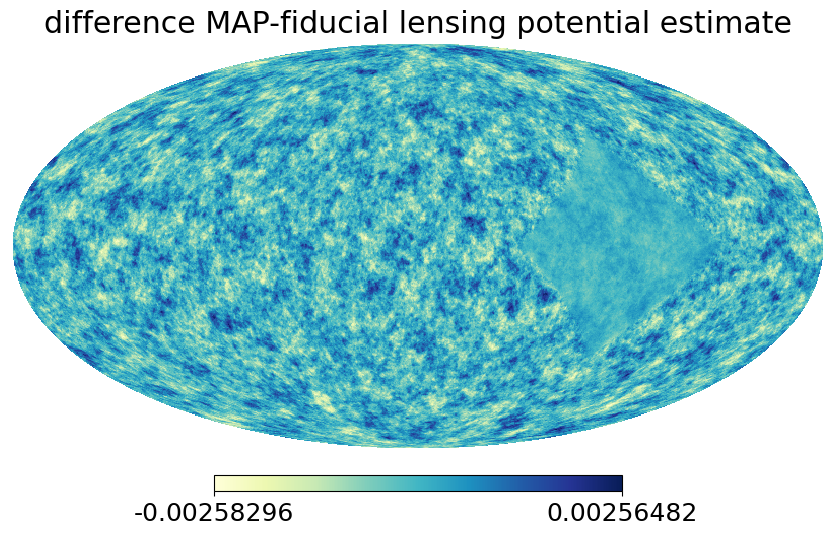

In [ ]:
mask_degrade = hp.ud_grade(mask, nside_out=256)
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=256)*mask_degrade, cmap='YlGnBu', title='lensing potential estimate, QE')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP[-1]), nside=256), cmap='YlGnBu', title='lensing potential estimate, MAP')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP[-1]-plm_in), nside=256), cmap='YlGnBu', title='difference MAP-fiducial lensing potential estimate')

# Delensed spectrum
For both QE and iterative lensing reconstruction, delensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps

In [ ]:
delensalot_runner = run(config_fn=fn, job_id='delens', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

In [ ]:
input_blensing = almxfl(alm_copy(ana_mwe._sims.get_sim_blm(ana_mwe.simidxs[0]), None, *ana_mwe.lm_max_blt), ana_mwe.ttebl['e'], ana_mwe.lm_max_blt[0], inplace=False) 

blens_residual_QE = ana_mwe.get_residualblens(ana_mwe.simidxs[0], 0)
blens_residual_MAP = ana_mwe.get_residualblens(ana_mwe.simidxs[0], ana_mwe.its[-1])

clbb = ana_mwe.read_data()

hp.mollview(hp.alm2map(input_blensing, nside=256))
hp.mollview(hp.alm2map(blens_residual_MAP, nside=256))

In [ ]:
plt.plot(hp.alm2cl(input_blensing, lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB{,}{\rm QE{,}RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB{,}{\rm MAP{,}RL}}$')

plt.plot(ana_mwe.edges_center, ana_mwe.ct[1:], color='black')
plt.plot(ana_mwe.edges_center, clbb[1,0,0,:]*ana_mwe.ct[1:], color='black')
plt.plot(ana_mwe.edges_center, clbb[2,0,0,:]*ana_mwe.ct[1:], color='black')

plt.legend(loc='lower right')
plt.xlim(0,210)
# plt.ylim(1e-7,1e-5)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

In [ ]:
lmin, lmax = (30, 200)
Alens_QE = np.mean(hp.alm2cl(blens_residual_QE, lmax_out=lmax)[lmin:lmax])/np.mean(hp.alm2cl(input_blensing, lmax_out=lmax)[lmin:lmax])
Alens_MAP = np.mean(hp.alm2cl(blens_residual_MAP, lmax_out=lmax)[lmin:lmax])/np.mean(hp.alm2cl(input_blensing, lmax_out=lmax)[lmin:lmax])  
print(20*'~.')
print(':::Empiric:::')
print('nlev: {}, lmax_ivf: {}, beam: {} arcmin '.format(str(ana_mwe.sims_nlev), ana_mwe.lm_max_ivf, ana_mwe.sims_beam))
print("A_L^QE: {:.3f}, A_L^MAP: {:.3f}".format(Alens_QE, Alens_MAP))
print(20*'~.')

# Summary and next steps
This tutorial demonstrated the usage of delensalot on a masked sky, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

delensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 
Further, it can calculate reconstruction noise $N_L^{(0)}$, and $N_L^{(1)}$, and make analytical predictions for the delensed power spectra.
It also has MPI support.
 
Please check out the [other tutorials](https://github.com/NextGenCMB/delensalot/blob/simgenjob/first_steps/), see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot) for more.